In [6]:
import numpy as np
import ode
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
from tqdm import tqdm

The equation of motion for a knuckleball has the form: $$C_L(\theta) = a_0 \sin(4\theta - \pi) + a_1 \sum_{i=1}^{n} \Big[\sin(\frac{||\mathbf{s_i}-\mathbf{p}||\pi}{2d} + \pi/2)\cdot \text{sgn}(p^{*}-s_{i}^{*})\Big].$$

Here, $\theta$ is the angle of attack on the ball. The first term accounts for vortex shedding *look up what this is*, and the second accounts for forces produced by the baseball's seams. 

0.9592659179738787

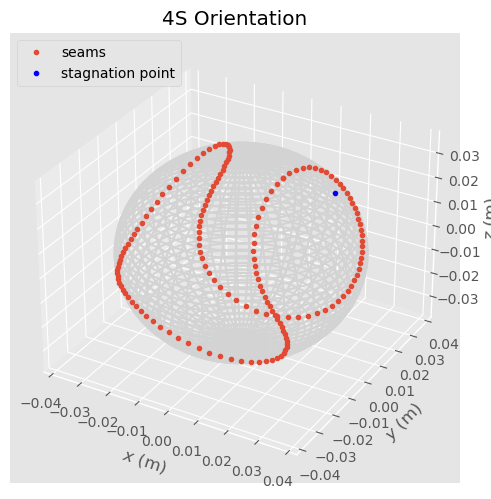

In [35]:
# alpha = np.linspace(1,6,162)
alpha = np.linspace(0,2*np.pi,162) # n=162 from source 
B = 0.6
F = 1
# R = 1
R = 0.07468/2
# unnormalized points
xu = np.cos(alpha) - B*np.cos(3*alpha)
yu = np.sin(alpha) + B*np.sin(3*alpha)
zu = F*np.cos(2*alpha)

ru_squared = 1 + B**2 + (F**2-2*B)*(np.cos(2*alpha))**2 + 2*B*(np.sin(2*alpha))**2
ru = np.sqrt(ru_squared)

x = R * xu/ru
y = R * yu/ru
z = R * zu/ru

# draw baseball
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
x_ball = np.outer(np.sin(u), np.sin(v))
y_ball = np.outer(np.sin(u), np.cos(v))
z_ball = np.outer(np.cos(u), np.ones_like(v))
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(R*x_ball, R*y_ball, R*z_ball,color='lightgray')
ax.plot(x, y, z, '.', label='seams')

#plot stagnation point
stag_x = 0.023
stag_y = 0.015
stag_z = 0.023
ax.plot(stag_x,stag_y,stag_z,'.',color='blue',label = 'stagnation point')

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
ax.set_zlabel("$z$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
ax.set_title('4S Orientation')
np.sqrt(stag_x**2+stag_y**2+stag_z**2)/R #checking that the stagnation point is on the surface of the sphere

In [36]:
def C_L_knuckleball(S,orientation=True):
    if orientation: # 4S orientation
        stag_x = 0.023
        stag_y = 0.015
        stag_z = 0.023
    else:
        stag_x = 0.
        stag_y = 0.
        stag_z = -0.04
    theta = S
    # vortex shedding term:
#     a0 = 0.0634*1e3
    a0 = 0.0634
    t1 = a0*np.sin(4*theta - np.pi)
    
    # seam term:
    dist_seam = np.zeros(alpha.shape[0])
    s_star = np.zeros(alpha.shape[0])
    for s_i in range(alpha.shape[0]):
        dist_seam[s_i] = np.sqrt((x[s_i]-stag_x)**2 + (y[s_i]-stag_y)**2 + (z[s_i]-stag_z)**2)
        s_star = z[s_i]
    d = 2 * R # ball diameter
#     a1 = 0.0062*1e3
    a1 = 0.0062

    t2 = a1*np.sum(((np.sin((np.linalg.norm(dist_seam)*np.pi / (2*d) + np.pi/2) * np.sign(stag_z - s_star)))))
    return t1 + t2

def C_L(S):
    return 0.62 * S**0.7

In [37]:
def simulate_baseball(v0, omega, r0=None,
                      h=0.01, C_D=0.40, g=9.81, rho=1.225,
                      r=0.07468/2, m=0.14883,
                      R_homeplate=18.4,knuckleball=False):
    """simulate baseball pitch
    
    Parameters
    ----------
    v0 : array
         initial velocity (vx, vy, vz) in m/s
    omega : array
         angular velocity vector of the ball ("spin"), in rad/s
    r0 : array, optional
         initial position of the ball (in m) when it leaves the pitcher's hand
         as (x, y, z); the default is (0, 2, 0)
    h : float, optional
         integration time step in s, default is 0.01 s
    C_D : float, optional
         drag coefficient, default is 0.40
    g : float, optional
         acceleration due to gravity, default 9.81 kg/(m*s^2)
    rho : float, optional
         density of air, default 1.225 kg/m^3
    r : float, optional
         radius of the baseball
    m : float, optional
         mass of the baseball
    R_homeplate : float, optional
         distance of the catcher from the pitcher
         
    Returns
    -------
    
    positions : array
         The array contains an entry (time, x, y, z) for each time step.
    """
    # all SI units (kg, m)
    if r0 is None:
        r0 = np.array([0, 2.0, 0])  # pitching at 2m height
    
    omega = np.asarray(omega)
        
    domega = np.linalg.norm(omega)
    A = np.pi*r**2
    rhoArm = rho * A * r / m
    b2 = 0.5 * C_D * rho * A
    
    a_gravity = np.array([0, -g, 0])

    def f(t, y):
        # y = [x, y, z, vx, vy, vz]
        v = y[3:]
        dv = np.linalg.norm(v)
        S = r*domega/dv
        if knuckleball:
            a_magnus = 0.5 * C_L_knuckleball(S*50) * rhoArm / S * np.cross(omega, v)
        else:
            a_magnus = 0.5 * C_L(S) * rhoArm / S * np.cross(omega, v)
        a_drag = -b2/m * dv * v
        a = a_gravity + a_drag + a_magnus
        return np.array([y[3], y[4], y[5],
                         a[0], a[1], a[2]])

    t = 0
    # initialize 3D!
    y = np.array([r0[0], r0[1], r0[2], v0[0], v0[1], v0[2]], dtype=np.float64)
    positions = [[t, y[0], y[1], y[2]]] # record t, x and y, z
    
#     while y[0] < R_homeplate and y[1] >= 0.2:
    while y[0] < R_homeplate and y[1] >= 0: # to compare with other references
        t += h
        y[:] = ode.rk4(y, f, t, h)
        positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
        
    return np.array(positions)

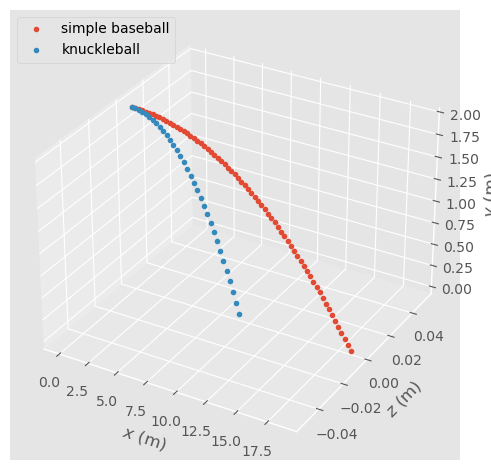

In [38]:
r = simulate_baseball([30, 0, 0], omega=0.001 * np.array([0,0,1]))
r2 = simulate_baseball([30, 0, 0], omega=0.001 * np.array([0,0,1]),knuckleball=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:,1], r[:,3], r[:,2], '.', label="simple baseball")
ax.plot(r2[:,1],r2[:,3],r2[:,2],'.',label='knuckleball')
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$z$ (m)")
ax.set_zlabel("$y$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()

In [47]:
theta_vals = np.arange(0,2*np.pi+np.pi/48,np.pi/48)
test = np.zeros(len(theta_vals))
test2 = np.zeros(len(theta_vals))
for i,theta in enumerate(theta_vals):
    test[i] = C_L_knuckleball(theta)
    test2[i] = C_L(theta)


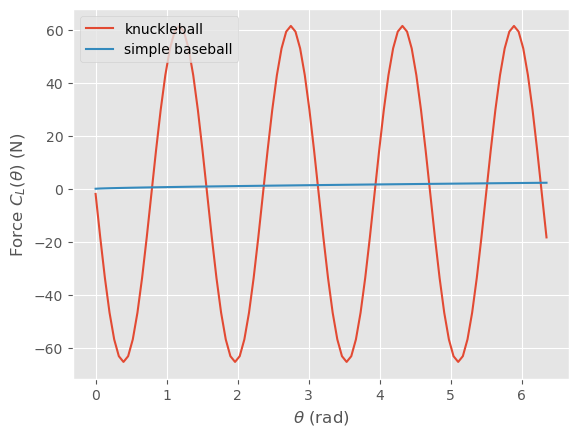

In [40]:
# lift force as a function of angle of attack/spin parameter
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta_vals,test,label='knuckleball')
ax.plot(theta_vals,test2,label='simple baseball')
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'Force $C_L(\theta)$ (N)')
ax.legend()
# conclusion: need to check larger values for a_0, a_1 to see appreciable effects? 

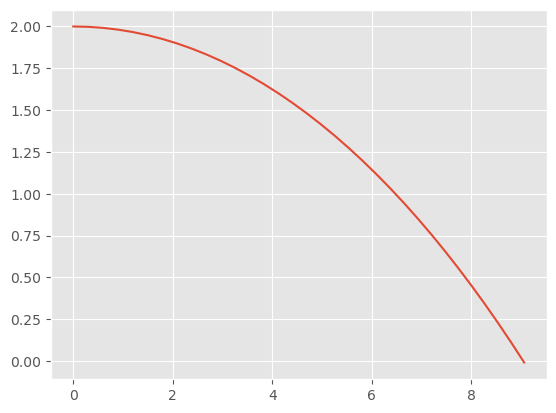

In [41]:
r = simulate_baseball([30,0,0],omega = 0.001 * np.array([0,0,1]),R_homeplate = 20,knuckleball=True)
idx = 2 
# plt.plot(r[:,0],r[:,idx],r2[:,0],r2[:,idx])
plt.plot(r[:,1],r[:,idx]) # distance to home versus height? 
# plt.xlabel('time (s)')

to plot seams: https://www.darenscotwilson.com/spec/bbseam/bbseam.html

1.0712372790573113

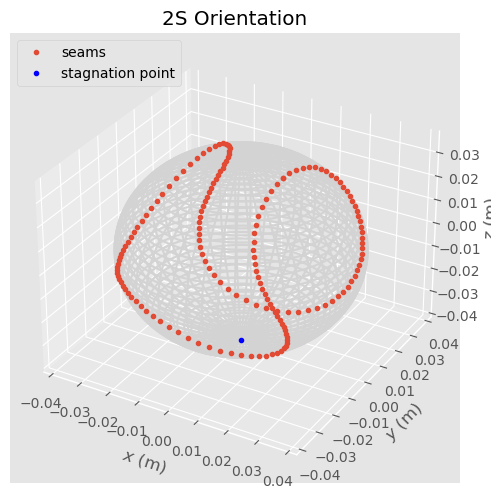

In [42]:
# alpha = np.linspace(1,6,162)
alpha = np.linspace(0,2*np.pi,162) # n=162 from source 
B = 0.6
F = 1
# R = 1
R = 0.07468/2
# unnormalized points
xu = np.cos(alpha) - B*np.cos(3*alpha)
yu = np.sin(alpha) + B*np.sin(3*alpha)
zu = F*np.cos(2*alpha)

ru_squared = 1 + B**2 + (F**2-2*B)*(np.cos(2*alpha))**2 + 2*B*(np.sin(2*alpha))**2
ru = np.sqrt(ru_squared)

x = R * xu/ru
y = R * yu/ru
z = R * zu/ru

# draw baseball
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
x_ball = np.outer(np.sin(u), np.sin(v))
y_ball = np.outer(np.sin(u), np.cos(v))
z_ball = np.outer(np.cos(u), np.ones_like(v))
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(R*x_ball, R*y_ball, R*z_ball,color='lightgray')
ax.plot(x, y, z, '.', label='seams')

#plot stagnation point
stag_x = 0.
stag_y = 0.
stag_z = -0.04
ax.plot(stag_x,stag_y,stag_z,'.',color='blue',label = 'stagnation point')

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
ax.set_zlabel("$z$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
# # fig.savefig("baseball.png")
ax.set_title('2S Orientation')
np.sqrt(stag_x**2+stag_y**2+stag_z**2)/R #checking that the stagnation point is on the surface of the sphere

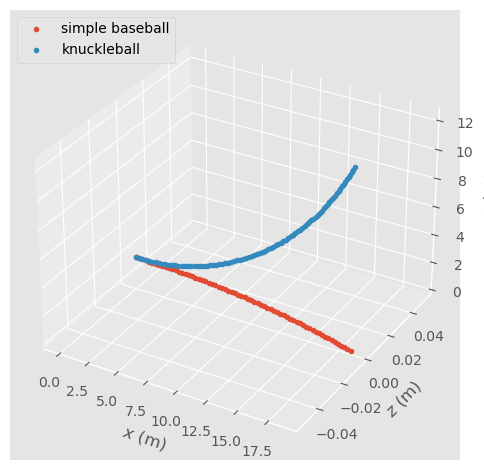

In [43]:
r = simulate_baseball([30, 0, 0], omega=0.001 * np.array([0,0,1]))
r2 = simulate_baseball([30, 0, 0], omega=0.001 * np.array([0,0,1]),knuckleball=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:,1], r[:,3], r[:,2], '.', label="simple baseball")
ax.plot(r2[:,1],r2[:,3],r2[:,2],'.',label='knuckleball')
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$z$ (m)")
ax.set_zlabel("$y$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()

In [44]:
theta_vals = np.arange(0,2*np.pi+np.pi/48,np.pi/48)
test = np.zeros(len(theta_vals))
test2 = np.zeros(len(theta_vals))
i = 0
for theta in theta_vals:
    test[i] = C_L_knuckleball(theta)
    test2[i] = C_L(theta)
    i += 1


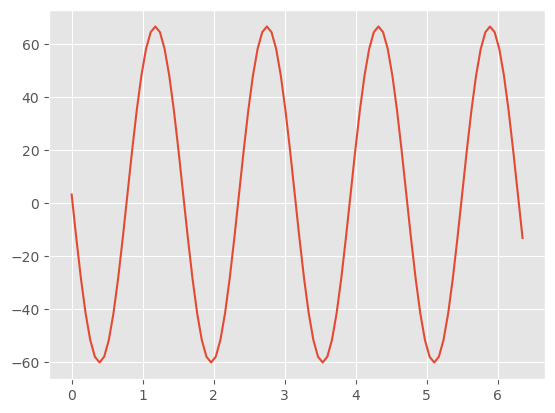

In [46]:
plt.plot(theta_vals,test)

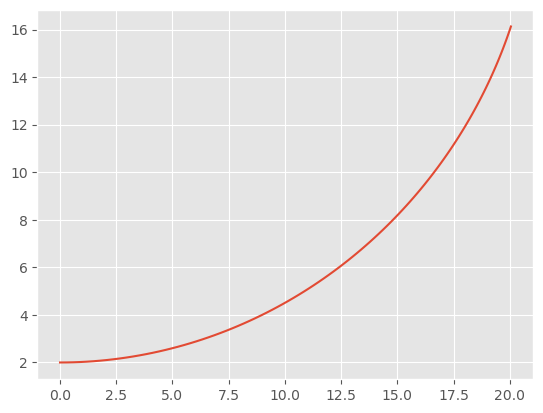

In [45]:
r = simulate_baseball([30,0,0],omega = 0.001 * np.array([0,0,1]),R_homeplate = 20,knuckleball=True)
idx = 2 
# plt.plot(r[:,0],r[:,idx],r2[:,0],r2[:,idx])
plt.plot(r[:,1],r[:,idx]) # distance to home versus height? 
# plt.xlabel('time (s)')